In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import time

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载 CIFAR - 10 数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# 定义教师模型
class TeacherNet(nn.Module):
    def __init__(self):
        super(TeacherNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 128 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 定义学生模型
class StudentNet(nn.Module):
    def __init__(self):
        super(StudentNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(x)
        x = x.view(-1, 32 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [53]:
# 记录程序开始时间
start_time = time.time()

# 训练教师模型
teacher_net = TeacherNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_net.parameters(), lr=0.001)

print("Training teacher model...")
teacher_start_time = time.time()
for epoch in range(5):  # 训练 5 个 epoch
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = teacher_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
teacher_end_time = time.time()
print('Finished training teacher model')
print(f'Teacher model training time: {teacher_end_time - teacher_start_time:.2f} seconds')

# 评估教师模型的准确率
teacher_net.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = teacher_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the teacher network on the 10000 test images: {100 * correct / total}%')

Training teacher model...
Epoch 1, Loss: 1.2392859047067828
Epoch 2, Loss: 0.8507791764447876
Epoch 3, Loss: 0.6526069539293446
Epoch 4, Loss: 0.4811579973191995
Epoch 5, Loss: 0.328118682770453
Finished training teacher model
Teacher model training time: 330.29 seconds
Accuracy of the teacher network on the 10000 test images: 72.63%


Training teacher model...
Epoch 1, Loss: 1.242666961287964
Epoch 2, Loss: 0.8509954760567316
Epoch 3, Loss: 0.6515265673074826
Epoch 4, Loss: 0.4870354615566598
Epoch 5, Loss: 0.332885346076882
Finished training teacher model
Teacher model training time: 125.96 seconds
Accuracy of the teacher network on the 10000 test images: 72.93%

In [11]:
# 模型蒸馏
student_net = StudentNet().to(device)
distillation_criterion = nn.KLDivLoss(reduction='batchmean')
student_optimizer = optim.Adam(student_net.parameters(), lr=0.001)
temperature = 4  # 蒸馏温度

print("Performing model distillation...")
distillation_start_time = time.time()
for epoch in range(5):  # 训练 5 个 epoch
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        student_optimizer.zero_grad()

        student_outputs = student_net(inputs)
        with torch.no_grad():
            teacher_outputs = teacher_net(inputs)

        # 计算蒸馏损失
        distillation_loss = distillation_criterion(
            nn.functional.log_softmax(student_outputs / temperature, dim=1),
            nn.functional.softmax(teacher_outputs / temperature, dim=1)
        ) * (temperature ** 2)

        # 计算分类损失
        classification_loss = criterion(student_outputs, labels)

        # 总损失
        total_loss = distillation_loss + classification_loss

        total_loss.backward()
        student_optimizer.step()

        running_loss += total_loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')
distillation_end_time = time.time()
print('Finished model distillation')
print(f'Model distillation time: {distillation_end_time - distillation_start_time:.2f} seconds')

Performing model distillation...
Epoch 1, Loss: 7.791591735505478
Epoch 2, Loss: 5.294122021242509
Epoch 3, Loss: 4.47205640227842
Epoch 4, Loss: 3.9654259527637192
Epoch 5, Loss: 3.647790292403062
Finished model distillation
Model distillation time: 105.03 seconds


In [13]:
torch.save(teacher_net, 'teacher_net.pth')
torch.save(student_net, 'student_net.pth')

In [14]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import time

# 定义学生模型
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载 CIFAR-10 数据集的一张图片
testset = CIFAR10(root='./data', train=False,
                  download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)
dataiter = iter(testloader)
images, labels = next(dataiter)

# 加载教师模型（ResNet-18）
teacher_model = models.resnet18(pretrained=True)
teacher_model.eval()

# 加载学生模型
student_model = StudentModel()
student_model.eval()

# 计算教师模型的推理时间
start_time_teacher = time.time()
with torch.no_grad():
    teacher_output = teacher_model(images)
end_time_teacher = time.time()
teacher_inference_time = end_time_teacher - start_time_teacher

# 计算学生模型的推理时间
start_time_student = time.time()
with torch.no_grad():
    student_output = student_model(images)
end_time_student = time.time()
student_inference_time = end_time_student - start_time_student

print(f"教师模型的推理时间: {teacher_inference_time:.6f} 秒")
print(f"学生模型的推理时间: {student_inference_time:.6f} 秒")

Files already downloaded and verified
教师模型的推理时间: 0.014664 秒
学生模型的推理时间: 0.000200 秒


/opt/anaconda3/envs/learning/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/learning/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
# 计算学生模型准确率的函数
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy


# 计算学生模型在测试集上的准确率
student_accuracy = calculate_accuracy(student_net, testloader)
print(f'Student model accuracy on test set: {student_accuracy * 100:.2f}%')

Student model accuracy on test set: 67.17%


In [16]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import time

# 定义设备
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 定义学生模型
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载 CIFAR-10 数据集
testset = CIFAR10(root='./data', train=False,
                  download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)


teacher_model = teacher_net
teacher_model = teacher_model.to(device)  # 将教师模型移到指定设备
teacher_model.eval()

student_model = student_net
student_model = student_model.to(device)  # 将学生模型移到指定设备
student_model.eval()

# 初始化统计变量
total_samples = len(testset)
both_correct = 0
both_wrong = 0
student_correct_teacher_wrong = 0
student_wrong_teacher_correct = 0

# 存储所有输出
student_outputs = []
teacher_outputs = []
labels_list = []

for images, labels in testloader:
    images = images.to(device)  # 将输入图像移到指定设备
    labels = labels.to(device)  # 将标签移到指定设备
    with torch.no_grad():
        teacher_output = teacher_model(images)
        student_output = student_model(images)
    
    student_outputs.append(student_output.cpu())  # 保存输出到 CPU 上
    teacher_outputs.append(teacher_output.cpu())  # 保存输出到 CPU 上
    labels_list.append(labels.cpu())  # 保存标签到 CPU 上

    _, student_predicted = torch.max(student_output.data, 1)
    _, teacher_predicted = torch.max(teacher_output.data, 1)

    if student_predicted.item() == labels.item() and teacher_predicted.item() == labels.item():
        both_correct += 1
    elif student_predicted.item() != labels.item() and teacher_predicted.item() != labels.item():
        both_wrong += 1
    elif student_predicted.item() == labels.item() and teacher_predicted.item() != labels.item():
        student_correct_teacher_wrong += 1
    elif student_predicted.item() != labels.item() and teacher_predicted.item() == labels.item():
        student_wrong_teacher_correct += 1

# 计算百分比
both_correct_percentage = (both_correct / total_samples) * 100
both_wrong_percentage = (both_wrong / total_samples) * 100
student_correct_teacher_wrong_percentage = (student_correct_teacher_wrong / total_samples) * 100
student_wrong_teacher_correct_percentage = (student_wrong_teacher_correct / total_samples) * 100

print(f"两者都正确的百分比: {both_correct_percentage:.2f}%")
print(f"两者都错误的百分比: {both_wrong_percentage:.2f}%")
print(f"学生正确，教师错误的百分比: {student_correct_teacher_wrong_percentage:.2f}%")
print(f"学生错误，教师正确的百分比: {student_wrong_teacher_correct_percentage:.2f}%")

# 保存输出
torch.save(student_outputs, 'student_outputs.pth')
torch.save(teacher_outputs, 'teacher_outputs.pth')
torch.save(labels_list, 'labels.pth')

Files already downloaded and verified
两者都正确的百分比: 59.64%
两者都错误的百分比: 19.66%
学生正确，教师错误的百分比: 7.53%
学生错误，教师正确的百分比: 13.17%


### 熵与准确率的关系

Student model accuracy on test set: 67.17%


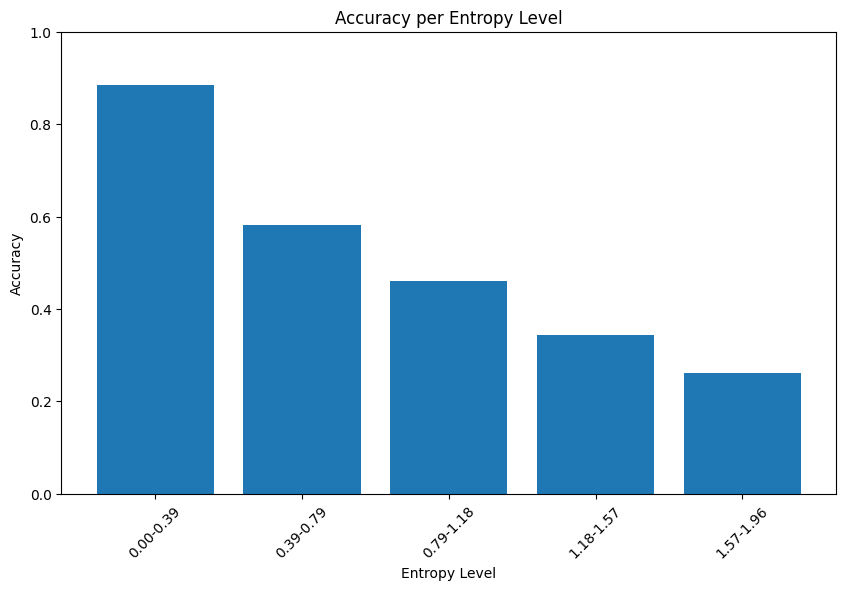

In [29]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


# 假设你已经定义了 device、student_net 和 testloader
# 修正设备检测逻辑，使用 mps 而不是错误的 cuda 判断
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 将 student_net 移动到指定设备
try:
    student_net = student_net.to(device)
except NameError:
    print("student_net 未定义，请确保已经正确定义该模型。")
    raise

# 计算学生模型准确率的函数
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy


# 计算熵和预测结果的函数
def calculate_entropy_and_predictions(model, dataloader):
    entropies = []
    predictions = []
    labels_list = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)
            _, predicted = torch.max(outputs.data, 1)

            entropies.extend(entropy.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return np.array(entropies), np.array(predictions), np.array(labels_list)


# 划分熵等级并计算各等级准确率的函数
def calculate_accuracy_per_entropy_level(entropies, predictions, labels, num_levels=5):
    min_entropy = np.min(entropies)
    max_entropy = np.max(entropies)
    entropy_bins = np.linspace(min_entropy, max_entropy, num_levels + 1)
    accuracy_per_level = []

    for i in range(num_levels):
        mask = (entropies >= entropy_bins[i]) & (entropies < entropy_bins[i + 1])
        if np.sum(mask) > 0:
            correct = np.sum(predictions[mask] == labels[mask])
            total = np.sum(mask)
            accuracy = correct / total
            accuracy_per_level.append(accuracy)
        else:
            accuracy_per_level.append(0)

    return entropy_bins, accuracy_per_level


# 计算学生模型在测试集上的准确率
student_accuracy = calculate_accuracy(student_net, testloader)
print(f'Student model accuracy on test set: {student_accuracy * 100:.2f}%')

# 计算熵和预测结果
entropies, predictions, labels = calculate_entropy_and_predictions(student_net, testloader)

# 划分熵等级并计算各等级准确率
entropy_bins, accuracy_per_level = calculate_accuracy_per_entropy_level(entropies, predictions, labels)

# 可视化不同等级熵的准确率
plt.figure(figsize=(10, 6))
plt.bar(range(len(accuracy_per_level)), accuracy_per_level, width=0.8)
plt.xticks(range(len(accuracy_per_level)), [f'{entropy_bins[i]:.2f}-{entropy_bins[i + 1]:.2f}' for i in range(len(accuracy_per_level))], rotation=45)
plt.title('Accuracy per Entropy Level')
plt.xlabel('Entropy Level')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

Student model accuracy on test set: 67.17%
Teacher model accuracy on test set: 72.81%


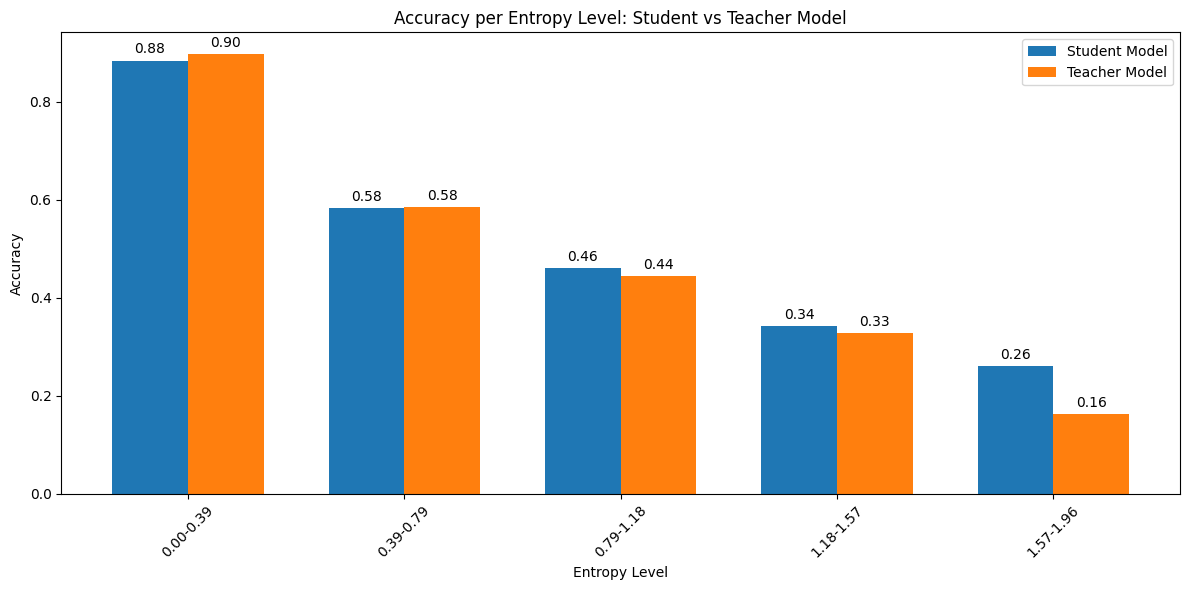

In [32]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经定义了 device、student_net、teacher_net 和 testloader
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 将 student_net 和 teacher_net 移动到指定设备
try:
    student_net = student_net.to(device)
    teacher_net = teacher_net.to(device)
except NameError:
    print("student_net 或 teacher_net 未定义，请确保已经正确定义这些模型。")
    raise

# 计算模型准确率的通用函数
def calculate_accuracy(model, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# 计算熵和预测结果的通用函数
def calculate_entropy_and_predictions(model, dataloader):
    entropies = []
    predictions = []
    labels_list = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)
            _, predicted = torch.max(outputs.data, 1)

            entropies.extend(entropy.cpu().numpy())
            predictions.extend(predicted.cpu().numpy())
            labels_list.extend(labels.cpu().numpy())

    return np.array(entropies), np.array(predictions), np.array(labels_list)

# 划分熵等级并计算各等级准确率的通用函数
def calculate_accuracy_per_entropy_level(entropies, predictions, labels, num_levels=5):
    min_entropy = np.min(entropies)
    max_entropy = np.max(entropies)
    entropy_bins = np.linspace(min_entropy, max_entropy, num_levels + 1)
    accuracy_per_level = []

    for i in range(num_levels):
        mask = (entropies >= entropy_bins[i]) & (entropies < entropy_bins[i + 1])
        if np.sum(mask) > 0:
            correct = np.sum(predictions[mask] == labels[mask])
            total = np.sum(mask)
            accuracy = correct / total
            accuracy_per_level.append(accuracy)
        else:
            accuracy_per_level.append(0)

    return entropy_bins, accuracy_per_level

# 计算学生模型在测试集上的准确率
student_accuracy = calculate_accuracy(student_net, testloader)
print(f'Student model accuracy on test set: {student_accuracy * 100:.2f}%')

# 计算学生模型的熵和预测结果
student_entropies, student_predictions, student_labels = calculate_entropy_and_predictions(student_net, testloader)

# 划分学生模型熵等级并计算各等级准确率
student_entropy_bins, student_accuracy_per_level = calculate_accuracy_per_entropy_level(student_entropies, student_predictions, student_labels)

# 计算教师模型在测试集上的准确率
teacher_accuracy = calculate_accuracy(teacher_net, testloader)
print(f'Teacher model accuracy on test set: {teacher_accuracy * 100:.2f}%')

# 计算教师模型的熵和预测结果
teacher_entropies, teacher_predictions, teacher_labels = calculate_entropy_and_predictions(teacher_net, testloader)

# 划分教师模型熵等级并计算各等级准确率
teacher_entropy_bins, teacher_accuracy_per_level = calculate_accuracy_per_entropy_level(teacher_entropies, teacher_predictions, teacher_labels)

# 可视化不同等级熵的准确率对比
x = np.arange(len(student_accuracy_per_level))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, student_accuracy_per_level, width, label='Student Model')
rects2 = ax.bar(x + width/2, teacher_accuracy_per_level, width, label='Teacher Model')

# 添加标题和标签
ax.set_ylabel('Accuracy')
ax.set_xlabel('Entropy Level')
ax.set_title('Accuracy per Entropy Level: Student vs Teacher Model')
ax.set_xticks(x)
ax.set_xticklabels([f'{student_entropy_bins[i]:.2f}-{student_entropy_bins[i + 1]:.2f}' for i in range(len(student_accuracy_per_level))], rotation=45)
ax.legend()

# 显示数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

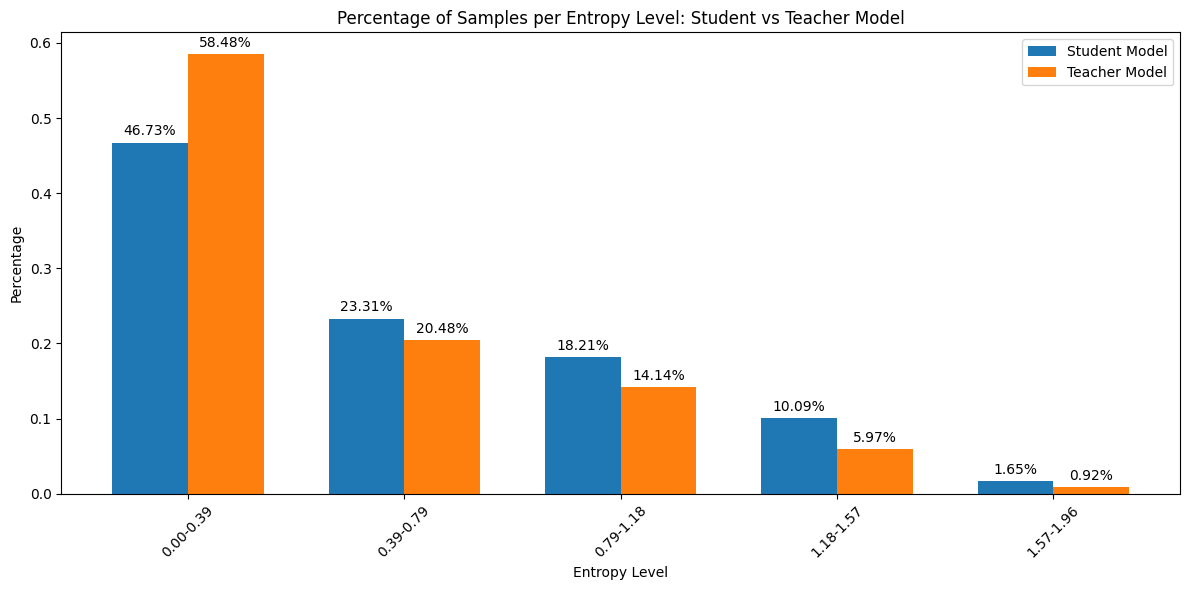

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# 计算学生模型各熵层级的样本数量
student_entropy_level_counts = []
for i in range(len(student_entropy_bins) - 1):
    mask = (student_entropies >= student_entropy_bins[i]) & (student_entropies < student_entropy_bins[i + 1])
    count = np.sum(mask)
    student_entropy_level_counts.append(count)

# 计算学生模型各熵层级的样本占比
student_entropy_level_percentages = [count / len(student_entropies) for count in student_entropy_level_counts]

# 计算教师模型各熵层级的样本数量
teacher_entropy_level_counts = []
for i in range(len(teacher_entropy_bins) - 1):
    mask = (teacher_entropies >= teacher_entropy_bins[i]) & (teacher_entropies < teacher_entropy_bins[i + 1])
    count = np.sum(mask)
    teacher_entropy_level_counts.append(count)

# 计算教师模型各熵层级的样本占比
teacher_entropy_level_percentages = [count / len(teacher_entropies) for count in teacher_entropy_level_counts]

# 可视化各熵层级的样本占比
x = np.arange(len(student_entropy_level_percentages))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, student_entropy_level_percentages, width, label='Student Model')
rects2 = ax.bar(x + width/2, teacher_entropy_level_percentages, width, label='Teacher Model')

# 添加标题和标签
ax.set_ylabel('Percentage')
ax.set_xlabel('Entropy Level')
ax.set_title('Percentage of Samples per Entropy Level: Student vs Teacher Model')
ax.set_xticks(x)
ax.set_xticklabels([f'{student_entropy_bins[i]:.2f}-{student_entropy_bins[i + 1]:.2f}' for i in range(len(student_entropy_level_percentages))], rotation=45)
ax.legend()

# 显示数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2%}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

In [36]:
import torch
import numpy as np

# 重新计算学生模型和教师模型的熵
student_entropies = []
teacher_entropies = []
with torch.no_grad():
    for data in testloader:
        images, _ = data[0].to(device), data[1].to(device)

        # 计算学生模型的输出和熵
        student_outputs = student_net(images)
        student_probabilities = torch.softmax(student_outputs, dim=1)
        student_entropy = -torch.sum(student_probabilities * torch.log(student_probabilities + 1e-10), dim=1)
        student_entropies.extend(student_entropy.cpu().numpy())

        # 计算教师模型的输出和熵
        teacher_outputs = teacher_net(images)
        teacher_probabilities = torch.softmax(teacher_outputs, dim=1)
        teacher_entropy = -torch.sum(teacher_probabilities * torch.log(teacher_probabilities + 1e-10), dim=1)
        teacher_entropies.extend(teacher_entropy.cpu().numpy())

student_entropies = np.array(student_entropies)
teacher_entropies = np.array(teacher_entropies)

# 划分学生模型熵等级
num_levels = 5
min_entropy = np.min(student_entropies)
max_entropy = np.max(student_entropies)
entropy_bins = np.linspace(min_entropy, max_entropy, num_levels + 1)

# 计算每个熵等级组的平均熵差值
avg_entropy_differences = []
for i in range(num_levels):
    mask = (student_entropies >= entropy_bins[i]) & (student_entropies < entropy_bins[i + 1])
    if np.sum(mask) > 0:
        group_student_entropies = student_entropies[mask]
        group_teacher_entropies = teacher_entropies[mask]
        entropy_differences = group_teacher_entropies - group_student_entropies
        avg_difference = np.mean(entropy_differences)
        avg_entropy_differences.append(avg_difference)
    else:
        avg_entropy_differences.append(0)

# 输出每个熵等级组的平均熵差值
for i, diff in enumerate(avg_entropy_differences):
    print(f"Entropy level {i + 1} ({entropy_bins[i]:.2f}-{entropy_bins[i + 1]:.2f}): Average entropy difference = {diff:.4f}")

Entropy level 1 (0.00-0.39): Average entropy difference = 0.0647
Entropy level 2 (0.39-0.79): Average entropy difference = -0.1232
Entropy level 3 (0.79-1.18): Average entropy difference = -0.3188
Entropy level 4 (1.18-1.57): Average entropy difference = -0.4940
Entropy level 5 (1.57-1.96): Average entropy difference = -0.6201


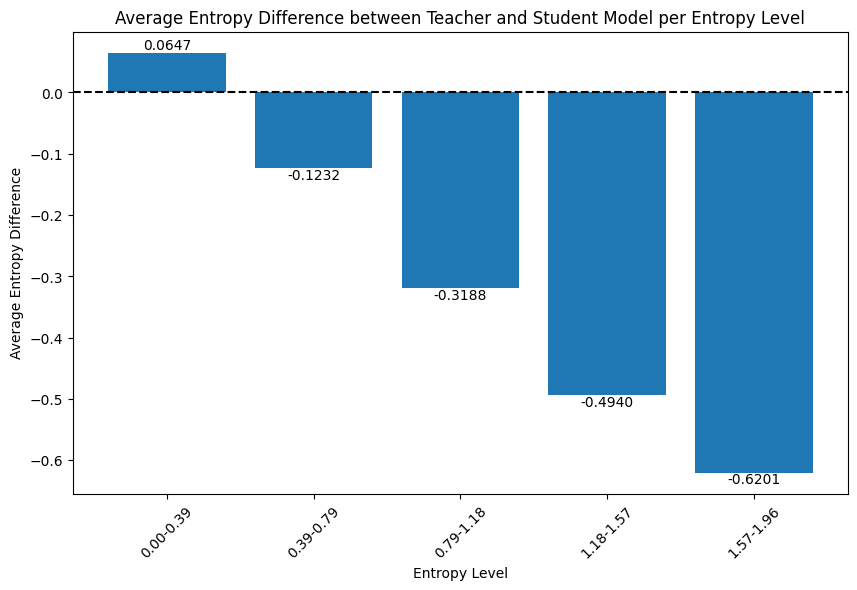

In [38]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 重新计算学生模型和教师模型的熵
student_entropies = []
teacher_entropies = []
with torch.no_grad():
    for data in testloader:
        images, _ = data[0].to(device), data[1].to(device)

        # 计算学生模型的输出和熵
        student_outputs = student_net(images)
        student_probabilities = torch.softmax(student_outputs, dim=1)
        student_entropy = -torch.sum(student_probabilities * torch.log(student_probabilities + 1e-10), dim=1)
        student_entropies.extend(student_entropy.cpu().numpy())

        # 计算教师模型的输出和熵
        teacher_outputs = teacher_net(images)
        teacher_probabilities = torch.softmax(teacher_outputs, dim=1)
        teacher_entropy = -torch.sum(teacher_probabilities * torch.log(teacher_probabilities + 1e-10), dim=1)
        teacher_entropies.extend(teacher_entropy.cpu().numpy())

student_entropies = np.array(student_entropies)
teacher_entropies = np.array(teacher_entropies)

# 划分学生模型熵等级
num_levels = 5
min_entropy = np.min(student_entropies)
max_entropy = np.max(student_entropies)
entropy_bins = np.linspace(min_entropy, max_entropy, num_levels + 1)

# 计算每个熵等级组的平均熵差值
avg_entropy_differences = []
for i in range(num_levels):
    mask = (student_entropies >= entropy_bins[i]) & (student_entropies < entropy_bins[i + 1])
    if np.sum(mask) > 0:
        group_student_entropies = student_entropies[mask]
        group_teacher_entropies = teacher_entropies[mask]
        entropy_differences = group_teacher_entropies - group_student_entropies
        avg_difference = np.mean(entropy_differences)
        avg_entropy_differences.append(avg_difference)
    else:
        avg_entropy_differences.append(0)

# 绘制直方图
plt.figure(figsize=(10, 6))
plt.bar(range(num_levels), avg_entropy_differences, width=0.8)
plt.xticks(range(num_levels), [f'{entropy_bins[i]:.2f}-{entropy_bins[i + 1]:.2f}' for i in range(num_levels)], rotation=45)
plt.title('Average Entropy Difference between Teacher and Student Model per Entropy Level')
plt.xlabel('Entropy Level')
plt.ylabel('Average Entropy Difference')
plt.axhline(y=0, color='black', linestyle='--')

# 添加数值标注
for i, v in enumerate(avg_entropy_differences):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom' if v >= 0 else 'top')

plt.show()

Entropy level 1 (0.00-0.39):
  Sample count: 4673
  Teacher correct, student wrong count: 166
Entropy level 2 (0.39-0.79):
  Sample count: 2331
  Teacher correct, student wrong count: 419
Entropy level 3 (0.79-1.18):
  Sample count: 1821
  Teacher correct, student wrong count: 431
Entropy level 4 (1.18-1.57):
  Sample count: 1009
  Teacher correct, student wrong count: 254
Entropy level 5 (1.57-1.96):
  Sample count: 165
  Teacher correct, student wrong count: 47


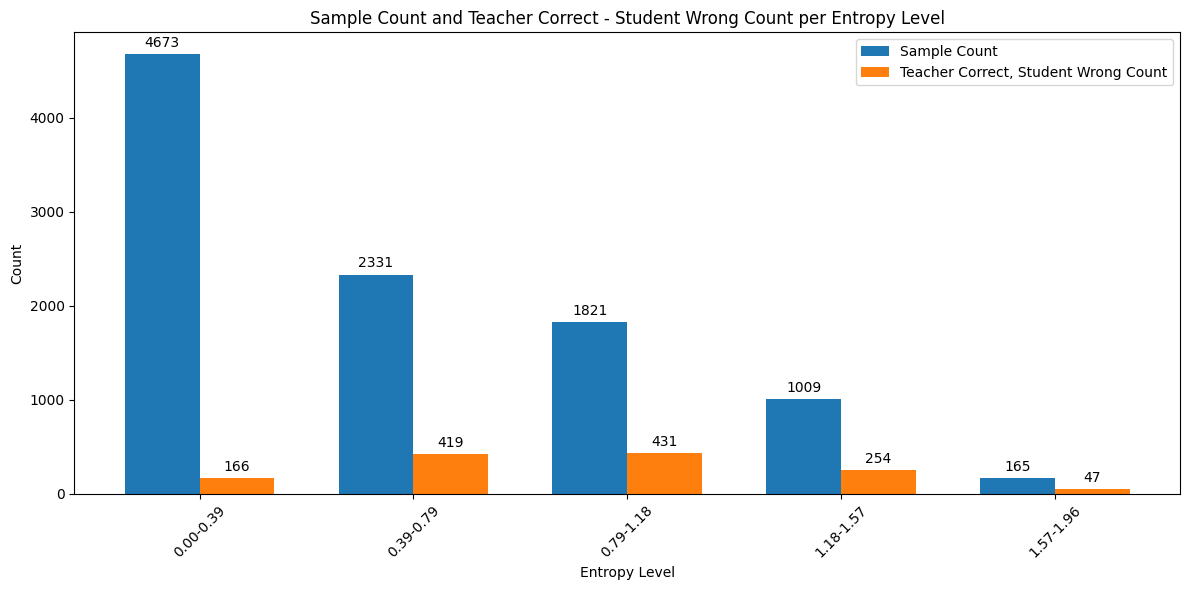

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 重新计算学生模型和教师模型的熵、预测结果
student_entropies = []
student_predictions = []
teacher_predictions = []
labels_list = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 学生模型
        student_outputs = student_net(images)
        student_probabilities = torch.softmax(student_outputs, dim=1)
        student_entropy = -torch.sum(student_probabilities * torch.log(student_probabilities + 1e-10), dim=1)
        _, student_pred = torch.max(student_outputs.data, 1)

        student_entropies.extend(student_entropy.cpu().numpy())
        student_predictions.extend(student_pred.cpu().numpy())

        # 教师模型
        teacher_outputs = teacher_net(images)
        _, teacher_pred = torch.max(teacher_outputs.data, 1)
        teacher_predictions.extend(teacher_pred.cpu().numpy())

        labels_list.extend(labels.cpu().numpy())

student_entropies = np.array(student_entropies)
student_predictions = np.array(student_predictions)
teacher_predictions = np.array(teacher_predictions)
labels_list = np.array(labels_list)

# 划分学生模型熵等级
num_levels = 5
min_entropy = np.min(student_entropies)
max_entropy = np.max(student_entropies)
entropy_bins = np.linspace(min_entropy, max_entropy, num_levels + 1)

# 计算每个熵等级的样本数、教师正确学生错误的数量
teacher_correct_student_wrong_counts = []
sample_counts = []
for i in range(num_levels):
    mask = (student_entropies >= entropy_bins[i]) & (student_entropies < entropy_bins[i + 1])
    group_student_pred = student_predictions[mask]
    group_teacher_pred = teacher_predictions[mask]
    group_labels = labels_list[mask]

    sample_count = len(group_labels)
    sample_counts.append(sample_count)

    correct_teacher = group_teacher_pred == group_labels
    wrong_student = group_student_pred != group_labels
    teacher_correct_student_wrong = correct_teacher & wrong_student
    teacher_correct_student_wrong_count = np.sum(teacher_correct_student_wrong)
    teacher_correct_student_wrong_counts.append(teacher_correct_student_wrong_count)

# 输出结果
for i in range(num_levels):
    print(f"Entropy level {i + 1} ({entropy_bins[i]:.2f}-{entropy_bins[i + 1]:.2f}):")
    print(f"  Sample count: {sample_counts[i]}")
    print(f"  Teacher correct, student wrong count: {teacher_correct_student_wrong_counts[i]}")

# 可视化结果
x = np.arange(num_levels)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, sample_counts, width, label='Sample Count')
rects2 = ax.bar(x + width/2, teacher_correct_student_wrong_counts, width, label='Teacher Correct, Student Wrong Count')

# 添加标题和标签
ax.set_ylabel('Count')
ax.set_xlabel('Entropy Level')
ax.set_title('Sample Count and Teacher Correct - Student Wrong Count per Entropy Level')
ax.set_xticks(x)
ax.set_xticklabels([f'{entropy_bins[i]:.2f}-{entropy_bins[i + 1]:.2f}' for i in range(num_levels)], rotation=45)
ax.legend()

# 显示数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

Entropy level 1 (0.00-0.39):
  Sample count: 4673
  Teacher correct, student wrong count: 166
  Teacher wrong, student correct count: 152
Entropy level 2 (0.39-0.79):
  Sample count: 2331
  Teacher correct, student wrong count: 419
  Teacher wrong, student correct count: 225
Entropy level 3 (0.79-1.18):
  Sample count: 1821
  Teacher correct, student wrong count: 431
  Teacher wrong, student correct count: 216
Entropy level 4 (1.18-1.57):
  Sample count: 1009
  Teacher correct, student wrong count: 254
  Teacher wrong, student correct count: 135
Entropy level 5 (1.57-1.96):
  Sample count: 165
  Teacher correct, student wrong count: 47
  Teacher wrong, student correct count: 25


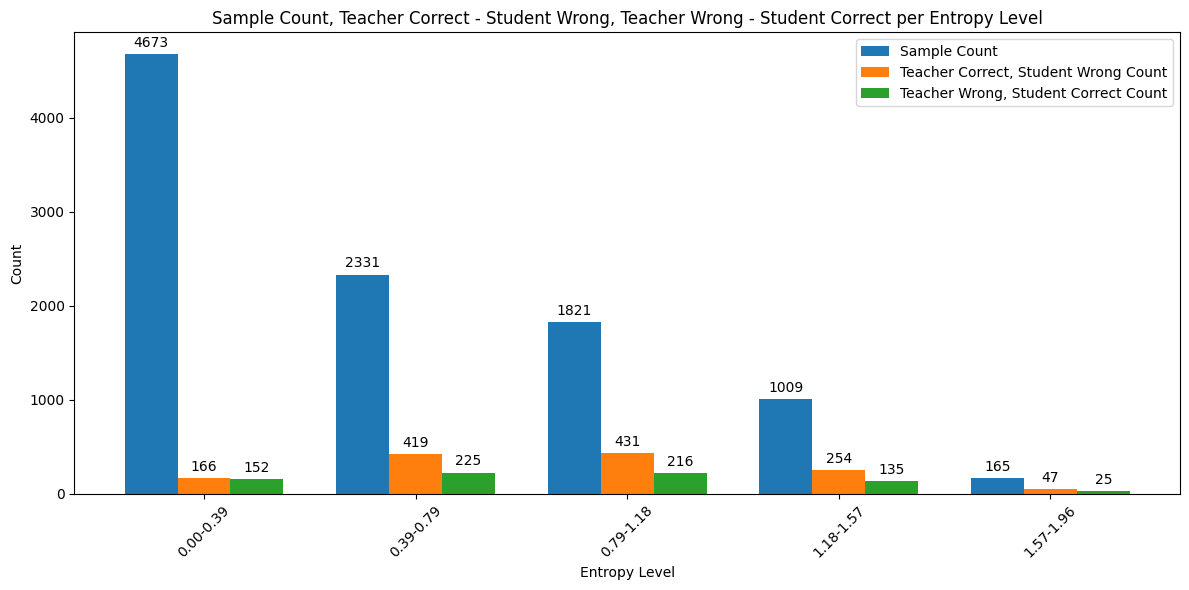

In [42]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 重新计算学生模型和教师模型的熵、预测结果
student_entropies = []
student_predictions = []
teacher_predictions = []
labels_list = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 学生模型
        student_outputs = student_net(images)
        student_probabilities = torch.softmax(student_outputs, dim=1)
        student_entropy = -torch.sum(student_probabilities * torch.log(student_probabilities + 1e-10), dim=1)
        _, student_pred = torch.max(student_outputs.data, 1)

        student_entropies.extend(student_entropy.cpu().numpy())
        student_predictions.extend(student_pred.cpu().numpy())

        # 教师模型
        teacher_outputs = teacher_net(images)
        _, teacher_pred = torch.max(teacher_outputs.data, 1)
        teacher_predictions.extend(teacher_pred.cpu().numpy())

        labels_list.extend(labels.cpu().numpy())

student_entropies = np.array(student_entropies)
student_predictions = np.array(student_predictions)
teacher_predictions = np.array(teacher_predictions)
labels_list = np.array(labels_list)

# 划分学生模型熵等级
num_levels = 5
min_entropy = np.min(student_entropies)
max_entropy = np.max(student_entropies)
entropy_bins = np.linspace(min_entropy, max_entropy, num_levels + 1)

# 计算每个熵等级的样本数、教师正确学生错误、教师错误学生正确的数量
teacher_correct_student_wrong_counts = []
teacher_wrong_student_correct_counts = []
sample_counts = []
for i in range(num_levels):
    mask = (student_entropies >= entropy_bins[i]) & (student_entropies < entropy_bins[i + 1])
    group_student_pred = student_predictions[mask]
    group_teacher_pred = teacher_predictions[mask]
    group_labels = labels_list[mask]

    sample_count = len(group_labels)
    sample_counts.append(sample_count)

    correct_teacher = group_teacher_pred == group_labels
    wrong_student = group_student_pred != group_labels
    teacher_correct_student_wrong = correct_teacher & wrong_student
    teacher_correct_student_wrong_count = np.sum(teacher_correct_student_wrong)
    teacher_correct_student_wrong_counts.append(teacher_correct_student_wrong_count)

    wrong_teacher = group_teacher_pred != group_labels
    correct_student = group_student_pred == group_labels
    teacher_wrong_student_correct = wrong_teacher & correct_student
    teacher_wrong_student_correct_count = np.sum(teacher_wrong_student_correct)
    teacher_wrong_student_correct_counts.append(teacher_wrong_student_correct_count)

# 输出结果
for i in range(num_levels):
    print(f"Entropy level {i + 1} ({entropy_bins[i]:.2f}-{entropy_bins[i + 1]:.2f}):")
    print(f"  Sample count: {sample_counts[i]}")
    print(f"  Teacher correct, student wrong count: {teacher_correct_student_wrong_counts[i]}")
    print(f"  Teacher wrong, student correct count: {teacher_wrong_student_correct_counts[i]}")

# 可视化结果
x = np.arange(num_levels)
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, sample_counts, width, label='Sample Count')
rects2 = ax.bar(x, teacher_correct_student_wrong_counts, width, label='Teacher Correct, Student Wrong Count')
rects3 = ax.bar(x + width, teacher_wrong_student_correct_counts, width, label='Teacher Wrong, Student Correct Count')

# 添加标题和标签
ax.set_ylabel('Count')
ax.set_xlabel('Entropy Level')
ax.set_title('Sample Count, Teacher Correct - Student Wrong, Teacher Wrong - Student Correct per Entropy Level')
ax.set_xticks(x)
ax.set_xticklabels([f'{entropy_bins[i]:.2f}-{entropy_bins[i + 1]:.2f}' for i in range(num_levels)], rotation=45)
ax.legend()

# 显示数值
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

### 下面是训练熵预测程

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np

# 定义设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载 CIFAR - 10 数据集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# 假设学生模型和教师模型已经定义并加载
# student_net = ...
# teacher_net = ...
student_net = student_net.to(device)
teacher_net = teacher_net.to(device)
student_net.eval()
teacher_net.eval()

# 计算熵的函数
def calculate_entropy(probabilities):
    return -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)

# 准备训练数据
train_inputs = []
train_targets = []
with torch.no_grad():
    for data in trainloader:
        images, _ = data[0].to(device), data[1].to(device)

        # 学生模型预测
        student_outputs = student_net(images)
        student_probabilities = torch.softmax(student_outputs, dim=1)
        student_entropy = calculate_entropy(student_probabilities)

        # 教师模型预测
        teacher_outputs = teacher_net(images)
        teacher_probabilities = torch.softmax(teacher_outputs, dim=1)
        teacher_entropy = calculate_entropy(teacher_probabilities)

        # 计算熵下降量
        entropy_decrease = student_entropy - teacher_entropy

        train_inputs.extend(student_probabilities.cpu().numpy())
        train_targets.extend(entropy_decrease.cpu().numpy())

train_inputs = np.array(train_inputs)
train_targets = np.array(train_targets)

# 定义预测模型
class EntropyDecreasePredictor(nn.Module):
    def __init__(self, input_size):
        super(EntropyDecreasePredictor, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 初始化预测模型
input_size = train_inputs.shape[1]
predictor = EntropyDecreasePredictor(input_size).to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(predictor.parameters(), lr=0.001)

# 训练预测模型
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(0, len(train_inputs), 32):
        inputs = torch.tensor(train_inputs[i:i + 32], dtype=torch.float32).to(device)
        targets = torch.tensor(train_targets[i:i + 32], dtype=torch.float32).unsqueeze(1).to(device)

        optimizer.zero_grad()

        outputs = predictor(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / (len(train_inputs) // 32)}')

# 评估预测模型
test_inputs = []
test_targets = []
with torch.no_grad():
    for data in testloader:
        images, _ = data[0].to(device), data[1].to(device)

        # 学生模型预测
        student_outputs = student_net(images)
        student_probabilities = torch.softmax(student_outputs, dim=1)
        student_entropy = calculate_entropy(student_probabilities)

        # 教师模型预测
        teacher_outputs = teacher_net(images)
        teacher_probabilities = torch.softmax(teacher_outputs, dim=1)
        teacher_entropy = calculate_entropy(teacher_probabilities)

        # 计算熵下降量
        entropy_decrease = student_entropy - teacher_entropy

        test_inputs.extend(student_probabilities.cpu().numpy())
        test_targets.extend(entropy_decrease.cpu().numpy())

test_inputs = torch.tensor(test_inputs, dtype=torch.float32).to(device)
test_targets = torch.tensor(test_targets, dtype=torch.float32).unsqueeze(1).to(device)

predictor.eval()
with torch.no_grad():
    test_outputs = predictor(test_inputs)
    test_loss = criterion(test_outputs, test_targets)
    print(f'Test Loss: {test_loss.item()}')

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Loss: 0.11981601514179789
Epoch 2, Loss: 0.10068643904945762
Epoch 3, Loss: 0.09971676720842891
Epoch 4, Loss: 0.09928919972849487
Epoch 5, Loss: 0.0990724456419026
Epoch 6, Loss: 0.09891181566398329
Epoch 7, Loss: 0.09880775664354675
Epoch 8, Loss: 0.09872454771516838
Epoch 9, Loss: 0.0986663163478621
Epoch 10, Loss: 0.09861747569090921
Test Loss: 0.1456117033958435


Files already downloaded and verified
All Teacher:
  Student model output count: 0 (0.00%)
  Teacher model output count: 20000 (100.00%)
  Accuracy: 72.63%
Predict Entropy Decrease:
  Student model output count: 3645 (36.45%)
  Teacher model output count: 6355 (63.55%)
  Accuracy: 72.98%
Predict Entropy Decrease > 0.1:
  Student model output count: 4749 (47.49%)
  Teacher model output count: 5251 (52.51%)
  Accuracy: 73.09%
All Student:
  Student model output count: 20000 (100.00%)
  Teacher model output count: 0 (0.00%)
  Accuracy: 67.17%


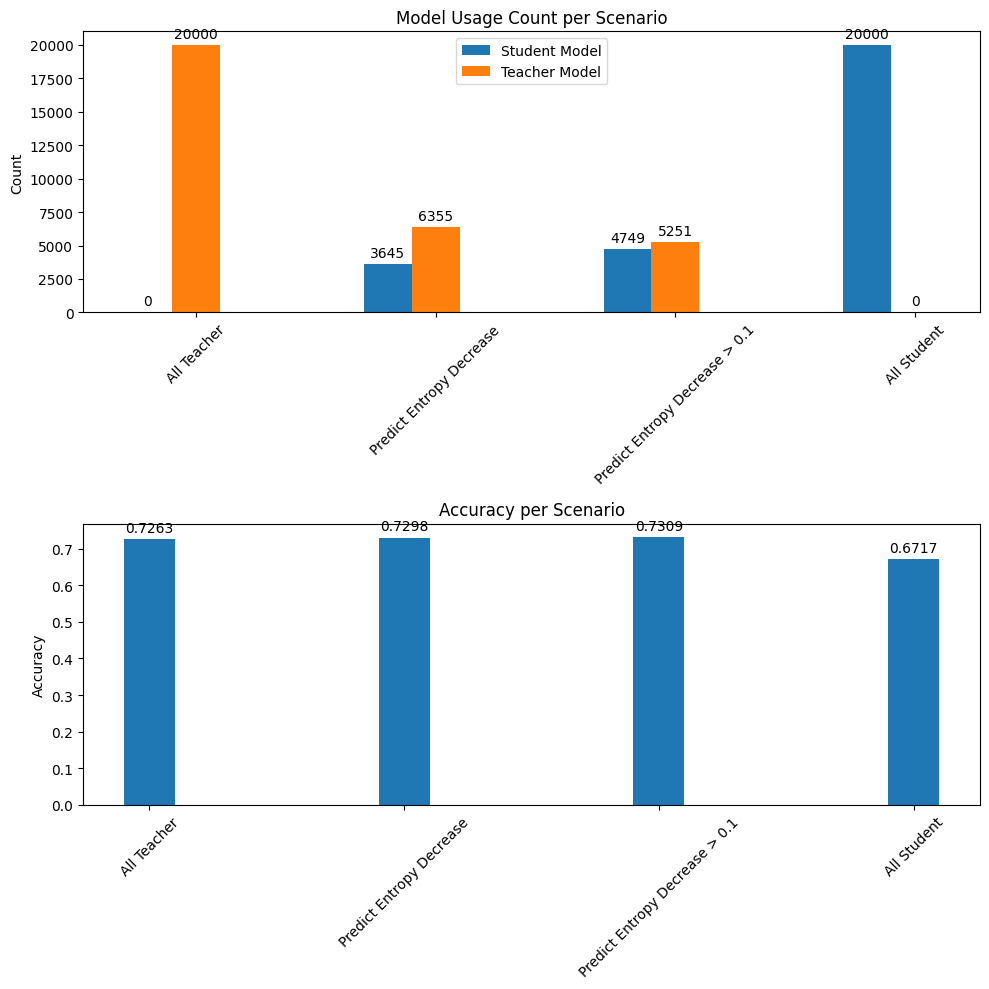

In [55]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# 定义设备
device = torch.device("mps" if torch.cuda.is_available() else "cpu")

# 数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 加载 CIFAR - 10 数据集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

# 假设学生模型、教师模型和熵预测模型已经定义并加载
# student_net = ...
# teacher_net = ...
# entropy_predictor = ...
student_net = student_net.to(device)
teacher_net = teacher_net.to(device)
entropy_predictor = predictor.to(device)
student_net.eval()
teacher_net.eval()
entropy_predictor.eval()

# 计算熵的函数
def calculate_entropy(probabilities):
    return -torch.sum(probabilities * torch.log(probabilities + 1e-10), dim=1)

# 准备测试数据
test_labels = []
student_outputs_list = []
teacher_outputs_list = []
entropy_decrease_pred_list = []
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 学生模型预测
        student_outputs = student_net(images)
        student_probabilities = torch.softmax(student_outputs, dim=1)

        # 教师模型预测
        teacher_outputs = teacher_net(images)
        teacher_probabilities = torch.softmax(teacher_outputs, dim=1)

        # 预测熵下降量
        entropy_decrease_pred = entropy_predictor(student_probabilities).squeeze()

        test_labels.extend(labels.cpu().numpy())
        student_outputs_list.extend(student_probabilities.cpu().numpy())
        teacher_outputs_list.extend(teacher_probabilities.cpu().numpy())
        entropy_decrease_pred_list.extend(entropy_decrease_pred.cpu().numpy())

test_labels = np.array(test_labels)
student_outputs_list = np.array(student_outputs_list)
teacher_outputs_list = np.array(teacher_outputs_list)
entropy_decrease_pred_list = np.array(entropy_decrease_pred_list)

# 四种判断情况
scenarios = [
    {
        "name": "All Teacher",
        "condition": lambda x: True,
        "student_count": 0,
        "teacher_count": len(test_labels),
        "accuracy": 0
    },
    {
        "name": "Predict Entropy Decrease",
        "condition": lambda x: x > 0,
        "student_count": 0,
        "teacher_count": 0,
        "accuracy": 0
    },
    {
        "name": "Predict Entropy Decrease > 0.1",
        "condition": lambda x: x > 0.1,
        "student_count": 0,
        "teacher_count": 0,
        "accuracy": 0
    },
    {
        "name": "All Student",
        "condition": lambda x: False,
        "student_count": len(test_labels),
        "teacher_count": 0,
        "accuracy": 0
    }
]

# 计算每种情况的结果
for scenario in scenarios:
    final_outputs = []
    for i in range(len(test_labels)):
        if scenario["condition"](entropy_decrease_pred_list[i]):
            final_outputs.append(teacher_outputs_list[i])
            scenario["teacher_count"] += 1
        else:
            final_outputs.append(student_outputs_list[i])
            scenario["student_count"] += 1

    final_outputs = np.array(final_outputs)
    final_predictions = np.argmax(final_outputs, axis=1)
    scenario["accuracy"] = np.mean(final_predictions == test_labels)

# 输出结果
for scenario in scenarios:
    total_count = scenario["student_count"] + scenario["teacher_count"]
    student_percentage = scenario["student_count"] / total_count * 100
    teacher_percentage = scenario["teacher_count"] / total_count * 100
    print(f"{scenario['name']}:")
    print(f"  Student model output count: {scenario['student_count']} ({student_percentage:.2f}%)")
    print(f"  Teacher model output count: {scenario['teacher_count']} ({teacher_percentage:.2f}%)")
    print(f"  Accuracy: {scenario['accuracy'] * 100:.2f}%")

# 可视化结果
names = [scenario["name"] for scenario in scenarios]
student_counts = [scenario["student_count"] for scenario in scenarios]
teacher_counts = [scenario["teacher_count"] for scenario in scenarios]
accuracies = [scenario["accuracy"] for scenario in scenarios]

x = np.arange(len(names))
width = 0.2

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# 绘制模型使用数量柱状图
rects1 = axs[0].bar(x - width, student_counts, width, label='Student Model')
rects2 = axs[0].bar(x, teacher_counts, width, label='Teacher Model')
axs[0].set_ylabel('Count')
axs[0].set_title('Model Usage Count per Scenario')
axs[0].set_xticks(x)
axs[0].set_xticklabels(names, rotation=45)
axs[0].legend()

# 显示模型使用数量数值
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1, axs[0])
autolabel(rects2, axs[0])

# 绘制准确率柱状图
rects3 = axs[1].bar(x, accuracies, width)
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy per Scenario')
axs[1].set_xticks(x)
axs[1].set_xticklabels(names, rotation=45)

# 显示准确率数值
autolabel(rects3, axs[1])

fig.tight_layout()
plt.show()